In [389]:
from bs4 import BeautifulSoup
import requests, re, dateutil.parser
import pandas as pd

#url = 'http://boxofficemojo.com/movies/?id=biglebowski.htm'
#url = 'http://www.boxofficemojo.com/movies/?page=main&id=conjuring2.htm'
#url = 'http://www.boxofficemojo.com/movies/?page=main&id=pixar2015.htm'
#url = 'http://www.boxofficemojo.com/movies/?page=main&id=kungfupanda3.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=illumination2015.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=labamba.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=starwars5.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=gildalive.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=thoselipsthoseeyes.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=starwars7.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=pups.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=girlfight.htm'

response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')

# Top 20 actors/actresses by gross earnings

In [390]:
url = 'http://www.boxofficemojo.com/people/?view=Actor&sort=sumgross&order=DESC&p=.htm'
response = requests.get(url)
page = response.text
soup_act = BeautifulSoup(page)

top_actors = set()
for node in soup_act.find_all('tr')[4:24]:
    top_actors.add(node.find_all('td')[1].text)

# Top 20 directors by gross earnings

In [391]:
url = 'http://www.boxofficemojo.com/people/?view=Director&sort=sumgross&order=DESC&p=.htm'
response = requests.get(url)
page = response.text
soup_act = BeautifulSoup(page)

top_directors = set()
for node in soup_act.find_all('tr')[4:24]:
    top_directors.add(node.find_all('td')[1].text)

# Testing individual scraping functions

In [ ]:
raw_title = soup.find('title').text
title = raw_title.split('(')[0]
print title

gross = soup.find(text=re.compile('Domestic')).find_next('b').text
gross = gross.replace('$','').replace(',', '')
gross = int(gross)
print gross

dist = soup.find(text='Distributor: ').find_next('b').text
print dist

date = soup.find(text='Release Date: ').find_next('b').text
date = dateutil.parser.parse(date)
print date

genre = soup.find(text='Genre: ').find_next('b').text
print genre

try:
    runtime = soup.find(text='Runtime: ').find_next('b').text
    runtime = runtime.split()
    runtime = int(runtime[0]) * 60 + int(runtime[2])
except ValueError:
    runtime = None
print runtime

rating = soup.find(text='MPAA Rating: ').find_next('b').text
print rating

try:
    budget = soup.find(text='Production Budget: ').find_next('b').text
    budget = budget.replace('$', '').split()[0]
    budget = int(budget)*1e6
except:
    budget = None
print budget

try:
    director = soup.find(text=re.compile('Director')).find_next('td')
    director = re.findall('>([A-Za-z\s.]+)<', str(director))
    print "Yes" if set(director) & set(top_directors) else "No"
except:
    print "No"

try:
    theaters = soup.find(text=re.compile('Widest')).find_next('td').text
    theaters = int(theaters.split()[0].replace(',', ''))
except:
    theaters = None
print theaters

try:
    actors = soup.find(text=re.compile('Actor')).find_next('td')
    actors = re.findall('>([A-Za-z\s.]+)<', str(actors))
    print len(set(actors) & set(top_actors))
except:
    print 0

# Actual scraping function for box office mojo

In [360]:
def scrape_page(url_string):
    response = requests.get(url_string)
    page = response.text
    soup = BeautifulSoup(page)
    
    ### title ###
    raw_title = soup.find('title').text
    title = raw_title.split('(')[0]
    
    ### gross domestic total ###
    gross = soup.find(text=re.compile('Domestic')).find_next('b').text
    gross = gross.replace('$','').replace(',', '')
    gross = int(gross)

    ### distributor ###
    dist = soup.find(text='Distributor: ').find_next('b').text

    ### release date ###
    date = soup.find(text='Release Date: ').find_next('b').text
    date = dateutil.parser.parse(date)

    ### genre ###
    genre = soup.find(text='Genre: ').find_next('b').text
    
    ### runtime ###
    try:
        runtime = soup.find(text='Runtime: ').find_next('b').text
        runtime = runtime.split()
        runtime = int(runtime[0]) * 60 + int(runtime[2])
    except ValueError:
        runtime = None

    ### MPAA rating ###
    rating = soup.find(text='MPAA Rating: ').find_next('b').text

    ### production budget ###
    try:
        budget = soup.find(text='Production Budget: ').find_next('b').text
        budget = budget.replace('$', '').split()[0]
        budget = int(budget)*1e6
    except:
        budget = None

    ### number of directors in top 50 director list ###
    try:
        director = soup.find(text=re.compile('Director')).find_next('td')
        director = re.findall('>([A-Za-z\s.]+)<', str(director))
        director = "Yes" if set(director) & set(top_directors) else "No"
    except:
        director = "No"
        
    ### number of theaters playing ###
    try:
        theaters = soup.find(text=re.compile('Widest')).find_next('td').text
        theaters = int(theaters.split()[0].replace(',', ''))
    except:
        theaters = None
    
    ### number of actors in top 50 actors list ###
    try:
        actors = soup.find(text=re.compile('Actor')).find_next('td')
        actors = re.findall('>([A-Za-z\s.]+)<', str(actors))
        actors = len(set(actors) & set(top_actors))
    except:
        actors = 0
    
    return [title, gross, dist, date, genre, runtime, rating, budget, director, theaters, actors, year]

# Testing on a single page

In [364]:
url = 'http://www.boxofficemojo.com/yearly/chart/?page=2&view=releasedate&view2=domestic&yr=1980&p=.htm'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page)
base = 'http://www.boxofficemojo.com'

movie_data = []
headers = ['Title', 'Domestic Total Gross', 'Distributor', 'Release Date', 'Genre', 'Runtime', 'MPAA Rating',
           'Production Budget', 'Director', 'Playing Theaters', 'Actors']

for node in soup.find_all('a'):
    try:
        if node.get('href').startswith('/movies') and not node.text.startswith('#1'):
            #print node.text
            features = scrape_page(str(base+node['href']))
            movie_dict = dict(zip(headers, features))
            movie_data.append(movie_dict)
            #print features
    except:
        continue

print movie_data[0]

{'Playing Theaters': None, 'MPAA Rating': u'R', 'Production Budget': None, 'Domestic Total Gross': 2261507, 'Title': u'Gilda Live ', 'Director': 'No', 'Genre': u'Unknown', 'Actors': 0, 'Distributor': u'Warner Bros.', 'Runtime': 90, 'Release Date': datetime.datetime(1980, 3, 28, 0, 0)}


# Testing on all pages of single year

In [16]:
url = 'http://www.boxofficemojo.com/yearly/chart/?page=1&view=releasedate&view2=domestic&yr=2015&p=.htm'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page)
base = 'http://www.boxofficemojo.com/'

movie_data = []
headers = ['Title', 'Domestic Total Gross', 'Distributor', 'Release Date', 'Genre', 'Runtime', 'MPAA Rating',
           'Production Budget', 'Director', 'Playing Theaters', 'Actors']

i = 1
while len(soup.find_all('a')) > 60:
    # scrape through single page
    for node in soup.find_all('a'):
        try:
            if node.get('href').startswith('/movies') and not node.text.startswith('#1'):
                features = scrape_page(str(base+node['href']))
                movie_dict = dict(zip(headers, features))
                movie_data.append(movie_dict)
        except:
            continue
    
    i += 1
    response = requests.get(url.replace('page=1', 'page=%d' % i))
    page = response.text
    soup = BeautifulSoup(page)

print movie_data[0]
# about 4 minutes for 700 entries

{'Playing Theaters': 4134, 'MPAA Rating': u'PG-13', 'Production Budget': u'$245 million', 'Domestic Total Gross': 936662225, 'Title': u'Star Wars: The Force Awakens', 'Director': u'J.J. Abrams', 'Genre': u'Sci-Fi Fantasy', 'Distributor': u'Buena Vista', 'Runtime': 136, 'Release Date': datetime.datetime(2015, 12, 18, 0, 0)}


# Testing on all movies from 2000 - 2016

In [ ]:
url = 'http://www.boxofficemojo.com/yearly/chart/?page=2&view=releasedate&view2=domestic&yr=1980&p=.htm'
base = 'http://www.boxofficemojo.com/'
movie_data = []
headers = ['Title', 'Domestic Total Gross', 'Distributor', 'Release Date', 'Genre', 'Runtime', 'MPAA Rating',
           'Production Budget', 'Director', 'Playing Theaters', 'Actors']

for year in range(1980, 2017):
    # i = 1
    url_new = url.replace('yr=1980', 'yr=%d' % year)
    response = requests.get(url_new)
    page = response.text
    soup = BeautifulSoup(page)

    # for given year, scroll through pages until we reach end
    # while len(soup.find_all('a')) > 60:
        
    # scrape through a single page
    for node in soup.find_all('a'):
        try:
            if node['href'].startswith('/movies') and not node.text.startswith('#1'):
                    
                # scrape data on individual movie page
                features = scrape_page(str(base+node['href']))
                movie_dict = dict(zip(headers, features))
                movie_data.append(movie_dict)
        except:
            continue
        
        # move onto next page
        # i += 1
        # response = requests.get(url_new.replace('page=1', 'page=%d' % i))
        # page = response.text
        # soup = BeautifulSoup(page)
    
    print 'Year %d: DONE' % year

df = pd.DataFrame(movie_data)
df.to_pickle('mojo2.pkl') # scraped data from second page of each year

# Add year to data frame to help with rotten tomatoes searching

In [392]:
df = pd.read_pickle('mojo.pkl')
df['Year'] = df['Release Date'].apply(lambda x: str(x.year))

df2 = pd.read_pickle('mojo2.pkl')
df2['Year'] = df2['Release Date'].apply(lambda x: str(x.year))

# Get fresh rating from single movie

In [ ]:
def get_fresh(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page)
    
    try:
        critic = soup.find(class_='critic-score meter').find(class_="meter-value superPageFontColor").text
    except:
        critic = None
    
    try:
        audience = soup.find(class_='audience-score meter').find('span').text
    except:
        audience = None
    
    return [critic, audience]

#url = 'https://www.rottentomatoes.com/m/ghostbusters_2016/'
#url = 'https://www.rottentomatoes.com/m/the_secret_life_of_pets'
#url = 'https://www.rottentomatoes.com/m/finding_dory'
#url = 'https://www.rottentomatoes.com/m/what_lies_beneath/?search=what%20lies%20beneath'
#url = 'https://www.rottentomatoes.com/m/1016534-popeye/'
#url = 'https://www.rottentomatoes.com/m/little_darlings/'

print get_fresh(url)

# Run rotten tomatoes scraper in parallel

In [388]:
from ipyparallel import Client

rc = Client()
dv = rc[:]

In [372]:
@dv.parallel()
def scrape_rt(row_iterable):
    from bs4 import BeautifulSoup
    from getfresh import get_fresh
    import requests, re
    
    base = 'https://www.rottentomatoes.com'
    headers = ['Title', 'Critic Score', 'Audience Score']
    rt_data = list()
    
    for i, row in enumerate(row_iterable):
        title = row[1][10]
        year = row[1][11]
        
        try:
            url = base + '/search/?search=' + title
            response = requests.get(url)
            page = response.text
            soup = BeautifulSoup(page)
    
            if soup.find_all(text=re.compile('Search Results')):
                for link in soup.find_all('a', href=True, text=re.compile(title + '$')):
                    if not link['href'].startswith('/m'):
                        continue
                    if year not in link.find_next(class_="movie_year").text:
                        continue
                    rt_dict = dict(zip(headers, [title] + get_fresh(base + link['href'])))
                    rt_data.append(rt_dict)
                    break
            else:
                try:
                    critic = soup.find(class_='critic-score meter').find(class_="meter-value superPageFontColor").text
                except:
                    critic = None
                
                try:
                    audience = soup.find(class_='audience-score meter').find('span').text
                except:
                    audience = None
            
                rt_dict = dict(zip(headers, [title, critic, audience]))
                rt_data.append(rt_dict)
        except:
            continue
    
    return rt_data

rotten_scores = scrape_rt(df2.iterrows()) # input second box office mojo data frame above

In [385]:
rotten_scores.done()
rotten_scores.successful()
data = rotten_scores.get()

df_rt = pd.DataFrame(data)
df_rt.head()
df_rt.to_pickle('rotten2.pkl')

# Combine datasets

In [1]:
import pandas as pd
from datetime import datetime
import dateutil
import numpy as np

# page 1 data set
df = pd.read_pickle('mojo.pkl')
rotten_df = pd.read_pickle('rotten.pkl')
result = pd.merge(df, rotten_df, how='left', on=['Title', 'Title'])

# page 2 data set
df2 = pd.read_pickle('mojo2.pkl')
rotten_df2 = pd.read_pickle('rotten2.pkl')
result2 = pd.merge(df2, rotten_df2, how='left', on=['Title', 'Title'])

# merge above two data sets
result = pd.concat([result,result2])
result.reset_index(drop=True, inplace=True)

# adding column for season
def season(x):
    if x in [12,1,2]:
        return 'Winter'
    elif x in [3,4,5]:
        return 'Spring'
    elif x in [6,7,8]:
        return 'Summer'
    else:
        return 'Fall'

result['Season'] = result['Release Date'].apply(lambda x: season(x.month))

result['String Date'] = result['Release Date']
result['Year'] = result['Release Date'].apply(lambda x: str(x.year))

# some extra processing
result['Audience Score'] = result['Audience Score'].apply(lambda x: int(x.split('%')[0]) if not pd.isnull(x) else None)
result['Critic Score'] = result['Critic Score'].apply(lambda x: int(x.split('%')[0]) if not pd.isnull(x) else None)
result['Release Date'] = result['Release Date'].apply(lambda x: datetime.toordinal(x))

In [4]:
# result.to_csv("movie_df.csv", index=False)
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7138 entries, 0 to 7137
Data columns (total 16 columns):
Actors                  7138 non-null int64
Director                7138 non-null object
Distributor             7138 non-null object
Domestic Total Gross    7138 non-null int64
Genre                   7138 non-null object
MPAA Rating             7138 non-null object
Playing Theaters        6655 non-null float64
Production Budget       2483 non-null float64
Release Date            7138 non-null int64
Runtime                 7097 non-null float64
Title                   7138 non-null object
Audience Score          4759 non-null float64
Critic Score            4759 non-null float64
Season                  7138 non-null object
String Date             7138 non-null datetime64[ns]
Year                    7138 non-null object
dtypes: datetime64[ns](1), float64(5), int64(3), object(7)
memory usage: 892.3+ KB


# Explore data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7138 entries, 0 to 7137
Data columns (total 16 columns):
Actors                  7138 non-null int64
Director                7138 non-null object
Distributor             7138 non-null object
Domestic Total Gross    7138 non-null int64
Genre                   7138 non-null object
MPAA Rating             7138 non-null object
Playing Theaters        6655 non-null float64
Production Budget       2483 non-null float64
Release Date            7138 non-null int64
Runtime                 7097 non-null float64
Title                   7138 non-null object
Audience Score          4759 non-null float64
Critic Score            4759 non-null float64
Season                  7138 non-null object
String Date             7138 non-null datetime64[ns]
Year                    7138 non-null object
dtypes: datetime64[ns](1), float64(5), int64(3), object(7)
memory usage: 892.3+ KB
None


Year
1980    61.027778
1981    59.855422
1982    62.131579
1983    61.744444
1984    61.821782
1985    64.862385
1986    58.672727
1987    63.958678
1988    59.858268
1989    59.572650
1990    59.810606
1991    61.573529
1992    62.255474
1993    62.825758
1994    57.808917
1995    61.583942
1996    57.834532
1997    60.134752
1998    60.355556
1999    63.591241
2000    60.867647
2001    61.940299
2002    60.584507
2003    62.329032
2004    63.342657
2005    63.231884
2006    64.423611
2007    65.445205
2008    59.781690
2009    58.077465
2010    58.374046
2011    61.656489
2012    64.965753
2013    64.568182
2014    62.242647
2015    61.153846
2016    66.294574
Name: Audience Score, dtype: float64

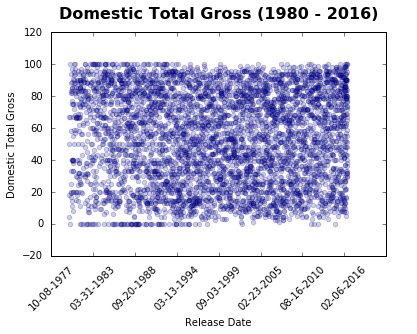

In [191]:
%matplotlib inline

# top grossing genres
result.groupby('Genre')['Domestic Total Gross'].mean().sort_values(ascending=False)

# top grossing MPAA ratings
result.groupby('MPAA Rating')['Domestic Total Gross'].mean().sort_values(ascending=False)

# top grossing studios
result.groupby('Distributor')['Domestic Total Gross'].mean().sort_values(ascending=False)

# animation vs. non-animation
result.loc[result['Genre'] == 'Animation']['Domestic Total Gross'].mean() # 76209702.1262
result.loc[result['Genre'] != 'Animation']['Domestic Total Gross'].mean() # 33090644.4453
len(result.loc[result['Genre'] == 'Animation']) # 309
len(result.loc[result['Genre'] != 'Animation']) # 6829

#result['Audience Score'].hist()
#result['Critic Score'].hist()
#result['Runtime'].hist()
#result['Playing Theaters'].hist()
#np.log(result['Domestic Total Gross']).hist() # very skewed

result.sort_values(by='Critic Score', ascending=False)['Title'][:5]
result.sort_values(by='Audience Score', ascending=False)['Title'][:5]

fig, ax = plt.subplots()
ax.scatter(result['Release Date'], result['Critic Score'], alpha=0.2)
ax.set_title('Domestic Total Gross (1980 - 2016)', fontsize=16, fontweight='bold', y=1.04)
ax.set_xlabel('Release Date')
ax.set_ylabel('Domestic Total Gross')
ax.tick_params(axis='both', which='major', pad=8)
dates = [datetime.fromordinal(x).strftime('%m-%d-%Y') for x in map(int, ax.get_xticks().tolist())]
ax.set_xticklabels(dates, rotation=45, ha='center')
ax.xaxis.get_major_ticks()[-1].set_visible(False)

print result.info()

result.groupby('Year')['Audience Score'].mean()
#result.groupby('MPAA Rating')['Critic Score'].size()

# production budget: linear, possibly quadratic?
# playing theaters: constant, slowly increasing exponential?

# Making plots for presentation

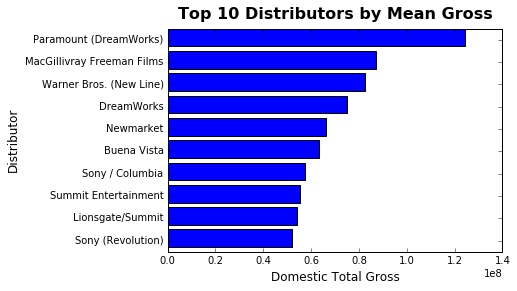

In [153]:
genre_gross = result.groupby('Distributor')['Domestic Total Gross'].mean().sort_values(ascending=False)

fig, ax = plt.subplots()
ax.barh(range(10), genre_gross[:10])
ax.set_yticklabels(genre_gross[:10].index, va='center')
ax.set_yticks(np.arange(10)+.5)
ax.set_title('Top 10 Distributors by Mean Gross', fontsize=16, fontweight='bold', y=1.02)
ax.set_xlabel('Domestic Total Gross', fontsize=12)
ax.set_ylabel('Distributor', fontsize=12)
plt.gca().invert_yaxis()

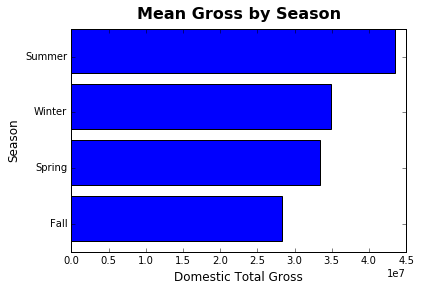

In [149]:
rating_gross = result.groupby('Season')['Domestic Total Gross'].mean().sort_values(ascending=False)

fig, ax = plt.subplots()
ax.barh(range(len(rating_gross)), rating_gross)
ax.set_yticklabels(rating_gross.index, va='center')
ax.set_yticks(np.arange(len(rating_gross))+.5)
ax.set_title('Mean Gross by Season', fontsize=16, fontweight='bold', y=1.02)
ax.set_xlabel('Domestic Total Gross', fontsize=12)
ax.set_ylabel('Season', fontsize=12)
plt.gca().invert_yaxis()

# Code categorical variables as indicators for regression

In [54]:
dist_cat = pd.get_dummies(result['Distributor'])
gen_cat = pd.get_dummies(result['Genre'])
rat_cat = pd.get_dummies(result['MPAA Rating'])
dir_cat = pd.get_dummies(result['Director'])
season_cat = pd.get_dummies(result['Season'])
                         
result = pd.concat([result, dist_cat, gen_cat, rat_cat, dir_cat, season_cat], axis=1)
result.drop(['Distributor', 'Genre', 'MPAA Rating','Director', 'Season'], axis=1, inplace=True)

# Split into two analyses (with and without production budget)

In [62]:
from sklearn import preprocessing

# data large does not include production budget
data_l = result.drop('Production Budget', axis=1)
data_l = data_l.dropna()
data_l = data_l.loc[:, ~data_l.apply(lambda x: np.all(x==0))]
data_l.reset_index(drop=True, inplace=True)

# data small includes production budget
data_s = result
data_s = data_s.dropna()
data_s = data_s.loc[:, ~data_s.apply(lambda x: np.all(x==0))]
data_s.reset_index(drop=True, inplace=True)

# Standardize all variables

In [ ]:
X_l = data_l[data_l.columns.difference(['Domestic Total Gross', 'Title'])]
y_l = data_l['Domestic Total Gross']

X_s = data_s[data_s.columns.difference(['Domestic Total Gross', 'Title'])]
y_s = data_s['Domestic Total Gross']

y_l=np.log(y_l)
y_s=np.log(y_s)

def standardize(x):
    return (x - x.mean()) / x.std()

# record standard deviations to un-normalize later
x_l_std = X_l.std()
x_s_std = X_s.std()
y_l_std = y_l.std()
y_s_std = y_s.std()

X_l = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_l), columns=X_l.columns)
X_s = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_s), columns=X_s.columns)

y_l = standardize(y_l)
y_s = standardize(y_s)

# Set up training and test sets

In [58]:
%matplotlib inline
from sklearn import linear_model, cross_validation, grid_search, preprocessing
import matplotlib.pyplot as plt

# split into training and hold-out test set
Xl_train, Xl_test, yl_train, yl_test = cross_validation.train_test_split(X_l.values, y_l.values, test_size=0.3, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = cross_validation.train_test_split(X_s.values, y_s.values, test_size=0.3, random_state=42)

# perform K-fold CV on training set
shuffler_l = cross_validation.KFold(len(Xl_train), n_folds=10, shuffle=True, random_state=42)
shuffler_s = cross_validation.KFold(len(Xs_train), n_folds=10, shuffle=True, random_state=42)

# Linear Regression

In [59]:
linear_l = linear_model.LinearRegression(fit_intercept=False)
linear_l.fit(Xl_train, yl_train)
#print linear_l.coef_
print cross_validation.cross_val_score(linear_l, Xl_train, yl_train, cv=shuffler_l).mean()

linear_s = linear_model.LinearRegression(fit_intercept=False)
linear_s.fit(Xs_train, ys_train)
print cross_validation.cross_val_score(linear_s, Xs_train, ys_train, cv=shuffler_s).mean()

-5.20126613317e+27
-1.6407242663e+27


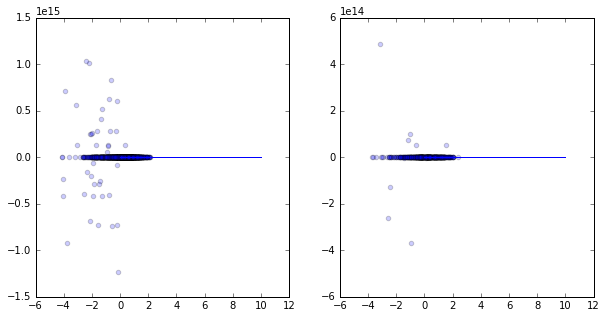

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
temp = np.linspace(0,10,30)
ax[0].scatter(yl_test, linear_l.predict(Xl_test), alpha=0.2)
ax[0].plot(temp,temp)

temp = np.linspace(0,10,30)
ax[1].scatter(ys_test, linear_s.predict(Xs_test), alpha=0.2)
ax[1].plot(temp,temp)

# LASSO

In [ ]:
parameters = {'alpha': np.linspace(.001, .1)}

lasso_l = linear_model.Lasso(fit_intercept=False)
grid_lasso_l = grid_search.GridSearchCV(lasso_l, parameters, cv=shuffler_l, n_jobs=4)
grid_lasso_l.fit(Xl_train,yl_train)

lasso_s = linear_model.Lasso(fit_intercept=False)
grid_lasso_s = grid_search.GridSearchCV(lasso_s, parameters, cv=shuffler_s, n_jobs=4)
grid_lasso_s.fit(Xs_train,ys_train)

In [224]:
print grid_lasso_l.best_score_, grid_lasso_l.best_params_
print grid_lasso_s.best_score_, grid_lasso_s.best_params_

best_alpha_l = grid_lasso_l.best_params_['alpha']
best_alpha_s = grid_lasso_s.best_params_['alpha']

0.593360199377 {'alpha': 0.0030204081632653063}
0.604788666088 {'alpha': 0.0090816326530612258}


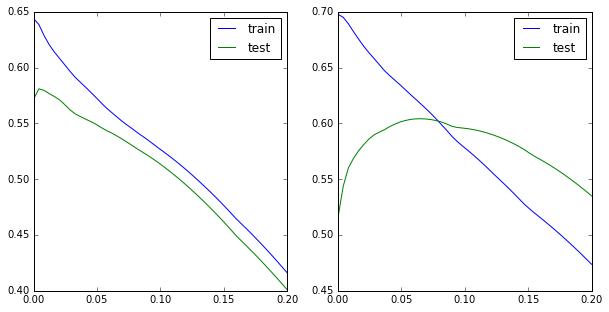

In [325]:
# create training and test sets out of original training set above
Xs_train_, Xs_test_, ys_train_, ys_test_ = cross_validation.train_test_split(Xs_train, ys_train, test_size=0.3, 
                                                                             random_state=42)
Xl_train_, Xl_test_, yl_train_, yl_test_ = cross_validation.train_test_split(Xl_train, yl_train, test_size=0.3, 
                                                                             random_state=42)
def plot_overfit_l(model_obj, param, param_range, ax):
    train = []
    test = []
    for a in param_range:
        model = model_obj()
        setattr(model, param, a)
        model.fit(Xl_train_, yl_train_)
        train.append(model.score(Xl_train_, yl_train_))
        test.append(model.score(Xl_test_, yl_test_))
    ax.plot(param_range, train, label='train')
    ax.plot(param_range, test, label='test')
    ax.legend()

def plot_overfit_s(model_obj, param, param_range, ax):
    train = []
    test = []
    for a in param_range:
        model = model_obj()
        setattr(model, param, a)
        model.fit(Xs_train_, ys_train_)
        train.append(model.score(Xs_train_, ys_train_))
        test.append(model.score(Xs_test_, ys_test_))
    ax.plot(param_range, train, label='train')
    ax.plot(param_range, test, label='test')
    ax.legend()

param_range = np.linspace(.0001,.2)
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_overfit_l(linear_model.Lasso, 'alpha', param_range, ax[0])
plot_overfit_s(linear_model.Lasso, 'alpha', param_range, ax[1])

0.625579104457
0.604229597154


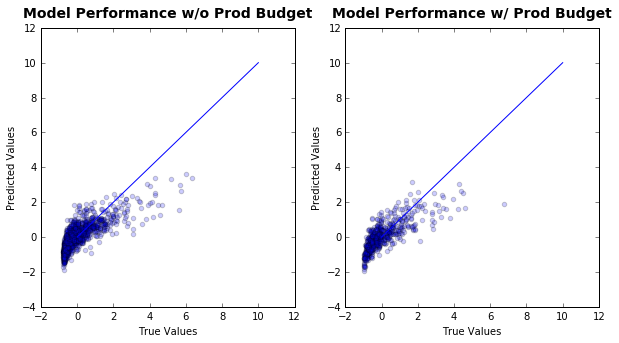

In [225]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

best_lasso_l = linear_model.Lasso(alpha=best_alpha_l, fit_intercept=False)
best_lasso_l.fit(Xl_train, yl_train)
temp = np.linspace(0,10,30)
ax[0].scatter(yl_test, best_lasso_l.predict(Xl_test), alpha=0.2)
ax[0].set_title('Model Performance w/o Prod Budget', fontsize=14, fontweight='bold', y=1.02)
ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
ax[0].plot(temp,temp)

best_lasso_s = linear_model.Lasso(alpha=best_alpha_s, fit_intercept=False)
best_lasso_s.fit(Xs_train, ys_train)
temp = np.linspace(0,10,30)
ax[1].scatter(ys_test, best_lasso_s.predict(Xs_test), alpha=0.2)
ax[1].set_title('Model Performance w/ Prod Budget', fontsize=14, fontweight='bold', y=1.02)
ax[1].set_xlabel('True Values')
ax[1].set_ylabel('Predicted Values')
ax[1].plot(temp,temp)

print best_lasso_l.score(Xl_test, yl_test)
print best_lasso_s.score(Xs_test, ys_test)

# Ridge Regression

In [ ]:
parameters = {'alpha': np.linspace(60, 110)}

ridge_l = linear_model.Ridge(fit_intercept=False)
grid_ridge_l = grid_search.GridSearchCV(ridge_l, parameters, cv=shuffler_l, n_jobs=4)
grid_ridge_l.fit(Xl_train,yl_train)

ridge_s = linear_model.Ridge(fit_intercept=False)
grid_ridge_s = grid_search.GridSearchCV(ridge_s, parameters, cv=shuffler_s, n_jobs=4)
grid_ridge_s.fit(Xs_train,ys_train)

In [179]:
print grid_ridge_l.best_score_, grid_ridge_l.best_params_
print grid_ridge_s.best_score_, grid_ridge_s.best_params_

best_alpha_l = grid_ridge_l.best_params_['alpha']
best_alpha_s = grid_ridge_s.best_params_['alpha']

0.593173941309 {'alpha': 73.265306122448976}
0.599355979594 {'alpha': 76.326530612244895}


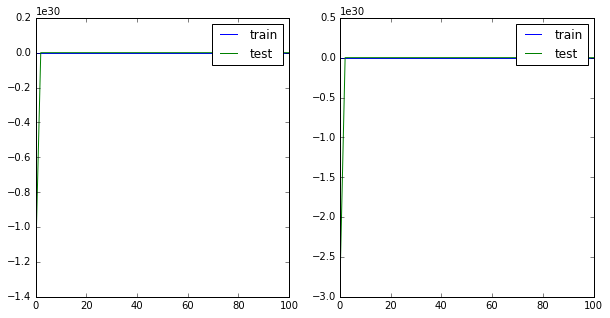

In [326]:
param_range = np.linspace(0,100)
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_overfit_l(linear_model.Ridge, 'alpha', param_range, ax[0])
plot_overfit_s(linear_model.Ridge, 'alpha', param_range, ax[1])

0.565885074194
0.59826887998


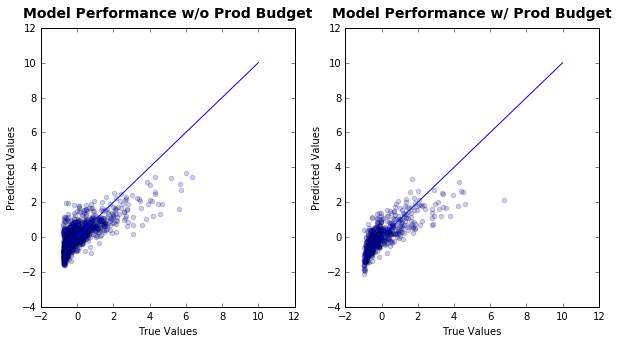

In [228]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

best_ridge_l = linear_model.Ridge(alpha=best_alpha_l, fit_intercept=False)
best_ridge_l.fit(Xl_train, yl_train)
temp = np.linspace(0,10,30)
ax[0].scatter(yl_test, best_ridge_l.predict(Xl_test), alpha=0.2)
ax[0].set_title('Model Performance w/o Prod Budget', fontsize=14, fontweight='bold', y=1.02)
ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
ax[0].plot(temp,temp)

best_ridge_s = linear_model.Ridge(alpha=best_alpha_s, fit_intercept=False)
best_ridge_s.fit(Xs_train, ys_train)
temp = np.linspace(0,10,30)
ax[1].scatter(ys_test, best_ridge_s.predict(Xs_test), alpha=0.2)
ax[1].set_title('Model Performance w/ Prod Budget', fontsize=14, fontweight='bold', y=1.02)
ax[1].set_xlabel('True Values')
ax[1].set_ylabel('Predicted Values')
ax[1].plot(temp,temp)

print best_ridge_l.score(Xl_test, yl_test)
print best_ridge_s.score(Xs_test, ys_test)

# Coefficients without prod budget

In [229]:
lasso_l_unstd = y_l_std/x_l_std * grid_lasso_l.best_estimator_.coef_
print sorted([(var, coef) for var, coef in zip(X_l.columns, lasso_l_unstd) if coef != 0], key=lambda x: x[1])

print
ridge_l_unstd = y_l_std/x_l_std * grid_ridge_l.best_estimator_.coef_
print sorted([(var, coef) for var, coef in zip(X_l.columns, ridge_l_unstd) if coef != 0], key=lambda x: x[1])

[(u'Blue Sky Cinema', -55302410.956472166), ('No', -43179883.205608651), (u'STX Entertainment', -26250654.797527686), (u'Western', -22143826.897727601), (u'Sony (Revolution)', -21517890.673054077), (u'Relativity', -19113763.992031261), (u'Weinstein / Dimension', -19026209.33358144), (u'Foreign / Action', -18532917.528432786), (u'Lionsgate/Summit', -18226171.994710166), (u'Action Drama', -18099136.537437402), (u'Fox Atomic', -17908797.633017611), (u'Sci-Fi Thriller', -17601039.233299859), (u'Open Road Films', -16176877.862771833), (u'Western Comedy', -16118398.742078206), (u'Sports Drama', -16065070.484812493), (u'Crime', -14956984.769210272), (u'Period Horror', -14934651.224885557), (u'War', -14290515.752504982), (u'Pure Flix', -14266449.679225516), (u'DreamWorks', -13913841.020438654), (u'Sci-Fi', -12328142.637352483), (u'MGM (Weinstein)', -12317232.090426797), (u'Drama / Thriller', -12075779.877842728), (u'Warner Bros. (New Line)', -11543942.442150837), (u'Overture Films', -11478114.

# Coefficients with prod budget

In [ ]:
lasso_s_unstd = y_s_std/x_s_std * grid_lasso_s.best_estimator_.coef_
print sorted([(var, coef) for var, coef in zip(X_s.columns, lasso_s_unstd) if coef != 0], key=lambda x: x[1])

ridge_s_unstd = y_s_std/x_s_std * grid_ridge_s.best_estimator_.coef_
print sorted([(var, coef) for var, coef in zip(X_s.columns, ridge_s_unstd) if coef != 0], key=lambda x: x[1])

# Random Forest

In [ ]:
from sklearn import ensemble

parameters = {'min_samples_leaf': np.arange(1,5)}

rf_l = ensemble.RandomForestRegressor(n_estimators=500, max_features='sqrt')
grid_rf_l = grid_search.GridSearchCV(rf_l, parameters, cv=shuffler_l, n_jobs=4)
grid_rf_l.fit(Xl_train,yl_train)

rf_s = ensemble.RandomForestRegressor(n_estimators=500, max_features='sqrt')
grid_rf_s = grid_search.GridSearchCV(rf_s, parameters, cv=shuffler_s, n_jobs=4)
grid_rf_s.fit(Xs_train,ys_train)

In [101]:
print grid_rf_l.best_score_
print grid_rf_l.best_params_

print grid_rf_s.best_score_
print grid_rf_s.best_params_

0.660258430233
{'min_samples_leaf': 1}
0.631566194127
{'min_samples_leaf': 1}


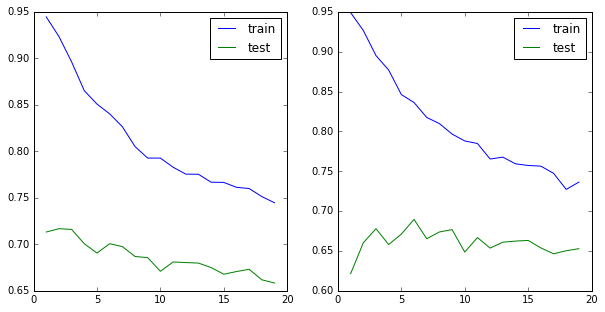

In [327]:
from sklearn import ensemble

param_range = np.arange(1, 20)
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_overfit_l(ensemble.RandomForestRegressor, 'min_samples_leaf', param_range, ax[0])
plot_overfit_s(ensemble.RandomForestRegressor, 'min_samples_leaf', param_range, ax[1])

0.688119962606
0.631432609791


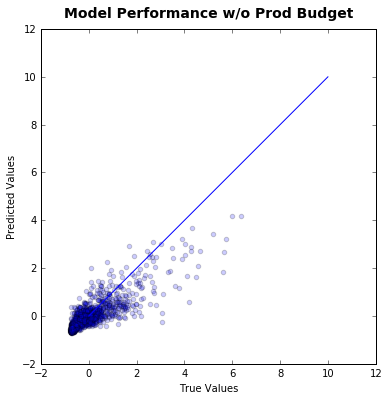

In [188]:
from sklearn import ensemble
temp = np.linspace(0,10,30)

fig, ax = plt.subplots(figsize=(6,6))
rf_l = ensemble.RandomForestRegressor(n_estimators=500, max_features='sqrt', min_samples_leaf=1, n_jobs=4)
rf_l.fit(Xl_train, yl_train)
ax.scatter(yl_test, rf_l.predict(Xl_test), alpha = .2)
ax.set_title('Model Performance w/o Prod Budget', fontsize=14, fontweight='bold', y=1.02)
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
ax.plot(temp,temp)

#rf_s = ensemble.RandomForestRegressor(n_estimators=500, max_features='sqrt', min_samples_leaf=1, n_jobs=4)
#rf_s.fit(Xs_train, ys_train)
#ax[1].scatter(ys_test, rf_s.predict(Xs_test), alpha = .2)
#ax[1].plot(temp,temp)

print rf_l.score(Xl_test, yl_test)
print rf_s.score(Xs_test, ys_test)

In [211]:
print sorted([(var, coef) for var, coef in zip(X_l.columns, rf_l.feature_importances_) if coef != 0],
             key=lambda x: abs(x[1]), reverse=True)

print sorted([(var, coef) for var, coef in zip(X_s.columns, rf_s.feature_importances_) if coef != 0],
             key=lambda x: abs(x[1]))

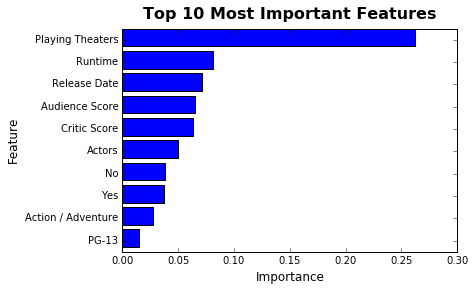

In [209]:
importances = rf_l.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
ax.barh(range(10), importances[indices][:10])
ax.set_yticklabels(X_l[indices][:10], va='center')
ax.set_yticks(np.arange(10)+.5)
ax.set_title('Top 10 Most Important Features', fontsize=16, fontweight='bold', y=1.02)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.gca().invert_yaxis()

# Gradient Boosting

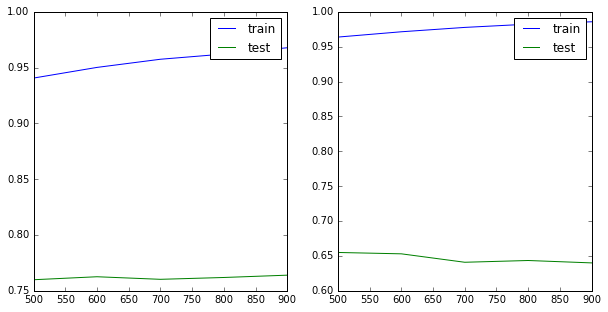

In [344]:
param_range = np.arange(500, 1000, 100)

fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_overfit_l(ensemble.GradientBoostingRegressor, 'n_estimators', param_range, ax[0])
plot_overfit_s(ensemble.GradientBoostingRegressor, 'n_estimators', param_range, ax[1])

In [ ]:
parameters = {'n_estimators': np.arange(100, 500, 100), 'min_samples_leaf': np.arange(1,4),
             'max_depth': np.arange(2,6)}

gb_l = ensemble.GradientBoostingRegressor(n_estimators=500, min_samples_leaf=2, max_depth=4)
grid_gb_l = grid_search.GridSearchCV(gb_l, parameters, cv=shuffler_l, n_jobs=4)
grid_gb_l.fit(Xl_train,yl_train)

gb_s = ensemble.GradientBoostingRegressor(n_estimators=500, min_samples_leaf=2, max_depth=3)
grid_gb_s = grid_search.GridSearchCV(gb_s, parameters, cv=shuffler_s, n_jobs=4)
grid_gb_s.fit(Xs_train,ys_train)

In [363]:
print grid_gb_l.best_score_
print grid_gb_l.best_params_

print grid_gb_s.best_score_
print grid_gb_s.best_params_

0.748201952475
{'n_estimators': 300, 'max_depth': 3, 'min_samples_leaf': 2}
0.71931701448
{'n_estimators': 200, 'max_depth': 2, 'min_samples_leaf': 2}


0.733341557334
0.682367311594


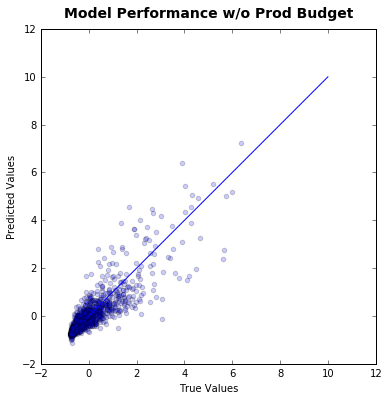

In [212]:
fig, ax = plt.subplots(figsize=(6,6))
gb_l = ensemble.GradientBoostingRegressor(n_estimators = 300, min_samples_leaf=2, max_depth=4)
gb_l.fit(Xl_train, yl_train)
ax.scatter(yl_test, gb_l.predict(Xl_test), alpha = .2)
ax.set_title('Model Performance w/o Prod Budget', fontsize=14, fontweight='bold', y=1.02)
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
ax.plot(temp,temp)

#gb_s = ensemble.GradientBoostingRegressor(n_estimators = 200, min_samples_leaf=2, max_depth=3)
#gb_s.fit(Xs_train, ys_train)
#ax[1].scatter(ys_test, gb_s.predict(Xs_test), alpha = .2)
#ax[1].plot(temp,temp)

print gb_l.score(Xl_test,yl_test)
print gb_s.score(Xs_test,ys_test)

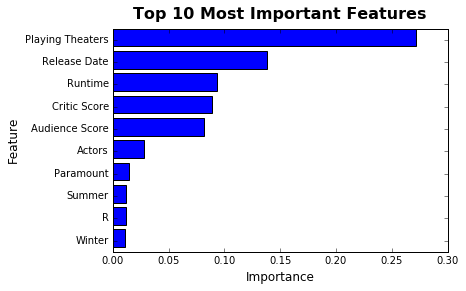

In [214]:
importances = gb_l.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
ax.barh(range(10), importances[indices][:10])
ax.set_yticklabels(X_l[indices][:10], va='center')
ax.set_yticks(np.arange(10)+.5)
ax.set_title('Top 10 Most Important Features', fontsize=16, fontweight='bold', y=1.02)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.gca().invert_yaxis()

In [ ]:
print sorted([(var, coef) for var, coef in zip(X_l.columns, gb_l.feature_importances_) if coef != 0],
             key=lambda x: abs(x[1]), reverse=True)

print sorted([(var, coef) for var, coef in zip(X_s.columns, gb_s.feature_importances_) if coef != 0],
             key=lambda x: abs(x[1]))